# Data preprocessing

The PBMC data consists of paired scATAC-seq and scRNA-seq profiles, but we treat them as unpaired.

In [1]:
import uniport as up
import numpy as np
import pandas as pd
import scanpy as sc

Read cell types

In [2]:
labels = pd.read_csv('PBMC/meta.txt', sep='\t')
celltype = labels['cluster'].values


Read gene activity matrix and RNA counts into AnnData objects. 

Prepare the gene activity matrix into `AnnData` objects using `load_file` fucntion in uniport.   

In [3]:
adata_atac = up.load_file('PBMC/gene_activity.txt')
adata_rna = up.load_file('PBMC/RNA_count.txt')

Add 'cell_type', 'domain_id' and 'source' to the `AnnData`objects.\
'cell_type' stores cell label annotations. \
'domain_id' identifies the modality using a number category. \
'source' identifies the modality using its name.

In [4]:
adata_atac.obs['cell_type'] = celltype
adata_atac.obs['domain_id'] = 0
adata_atac.obs['domain_id'] = adata_atac.obs['domain_id'].astype('category')
adata_atac.obs['source'] = 'ATAC'

adata_rna.obs['cell_type'] = celltype
adata_rna.obs['domain_id'] = 1
adata_rna.obs['domain_id'] = adata_rna.obs['domain_id'].astype('category')
adata_rna.obs['source'] = 'RNA'

Filter cells and features using `filter_data` function in uniport. 

In [5]:
adata_atac = up.filter_data(adata_atac, min_features=3, min_cells=200)
adata_rna = up.filter_data(adata_rna, min_features=3, min_cells=200)
print(adata_atac)
print(adata_rna)

AnnData object with n_obs × n_vars = 11259 × 14867
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells'
AnnData object with n_obs × n_vars = 11259 × 11942
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells'


Use `AnnData.concatenate` to concatenate scATAC-seq and scRNA-seq with common genes

In [6]:
adata_cm = adata_atac.concatenate(adata_rna, join='inner', batch_key='domain_id')
print(adata_cm)

AnnData object with n_obs × n_vars = 22518 × 8275
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1'


Preprocess data with common genes. Select 2,000 highly variable common genes. \
Scale data using `batch_scale` function in uniport (from SCALEX).

In [7]:
sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
sc.pp.highly_variable_genes(adata_cm, n_top_genes=2000, batch_key='domain_id', inplace=False, subset=True)
adata_cm = up.batch_scale(adata_cm)
print(adata_cm)

AnnData object with n_obs × n_vars = 22518 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'


Preprocess scATAC-seq data.
Select 2,000 highly variable genes as ATAC speicifc.

In [8]:
sc.pp.normalize_total(adata_atac)
sc.pp.log1p(adata_atac)
sc.pp.highly_variable_genes(adata_atac, n_top_genes=2000, inplace=False, subset=True)
adata_atac = up.batch_scale(adata_atac)
print(adata_atac)

AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


Preprocess scRNA-seq data. Select 2,000 highly variable genes as RNA specific.

In [9]:
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, inplace=False, subset=True)
adata_rna = up.batch_scale(adata_rna)
print(adata_rna)

AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


Save the preprocessed data for integration.

In [10]:
adata_atac.write('PBMC/atac.h5ad', compression='gzip')
adata_rna.write('PBMC/rna.h5ad', compression='gzip')
adata_cm.write('PBMC/atac_and_rna.h5ad', compression='gzip')

Visualize the data using UMAP according to their cell types and sources.

In [11]:
sc.pp.pca(adata_cm)
sc.pp.neighbors(adata_cm)
sc.tl.umap(adata_cm)

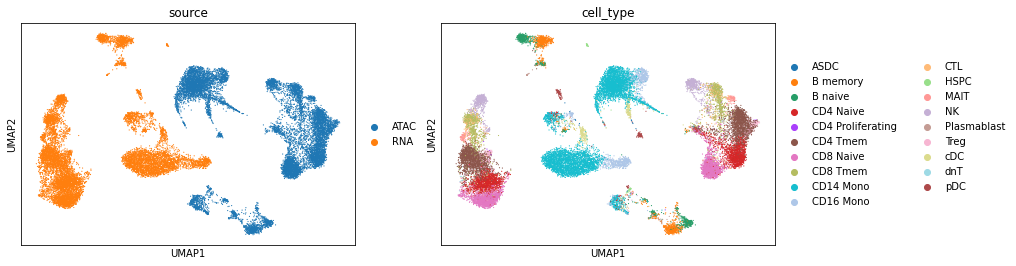

In [12]:
sc.pl.umap(adata_cm, color=['source', 'cell_type'])